#Обучение классификатора на реальном датасете.

##Пояснение:
Требуется обучить классификатор определяющий тип велосипеда на небольшом датасете фотографий велосипедов из открытых источников. Допускается использовать пред-обученные модели из torchvision.models
По результатам работы составьте отчет.

##Задачи:

* Загрузите Датасет по ссылке: http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip Используйте встроенные классы из пакета torchvision.datasets либо создайте свой являющийся наследником базового класса Dataset из этого пакета.
* Проведите аугментацию данных как минимум 3-мя различными способами. Хотя бы одни из них должен быть реализован самостоятельно.
* Используйте технологию Transfer learning: 
** измените выходной слой выбранной вами предобученной модели.
** Заморозьте часть весов.
* Обучите модель с использование GPU. Учитывайте особенности данных при выборе и настройке Loss-функции
*Оцените результаты.
* Напишите отчет.



*Сохраняйте веса модели на GoogleDrive

## Подготовка датасета

In [1]:
!wget -nc http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

--2022-12-03 10:34:00--  http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110280897 (105M) [application/zip]
Saving to: ‘bt_dataset3.zip’

bt_dataset3.zip     100%[===================>] 105.17M  9.13MB/s    in 31s     

2022-12-03 10:34:33 (3.41 MB/s) - ‘bt_dataset3.zip’ saved [110280897/110280897]



In [2]:
!rm -rf bike/
!unzip bt_dataset3.zip >/dev/null

In [3]:
import random, os
import numpy as np
import torch

# фиксируем сид
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True
  
seed_everything(122)

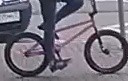

In [4]:
# смотрим на рандомную картинку из датасета
from glob import glob
from PIL import Image

Image.open(random.choice(glob("bike/**/*.jpeg", recursive=True)))

Получился русский велик с логотипом ВТБ. Какое совпадение...

In [5]:
# сейчас будет небольшая путаница с порядком действий
# дело в том, что чтобы подгрузить датасет, нужны трнсформеры
# а для трансформеров нужны аугментации
# одну из которых мне надо написать ручкам
# такчто вот пишум аугментацию

class RandomBlackBox:
  def __init__(self, p=0.5, min_size=10, max_size=20):
    self.p = p
    self.min_size = min_size
    self.max_size = max_size

  def __call__(self, img: torch.Tensor):
    # с вероятностью 1-p мы ничего неделаем
    if np.random.random() >= self.p:
      return img

    size = min(img.shape[1], img.shape[2])
    xs, ys = np.indices([img.shape[1], img.shape[2]])
    x1y1 = np.random.randint(size - self.max_size - 1, size=2)
    x2y2 = x1y1 + np.random.randint(self.min_size, self.max_size, size=2)
    x1, y1 = x1y1
    x2, y2 = x2y2

    mask = (xs >= x1) & (xs <= x2) & (ys >= y1) & (ys <= y2)
    return torch.tensor(1-mask) * img


In [6]:
# определяем трансформы
import torchvision.transforms as trans

IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# будем ручками менять это число, чтобы опробывать разные варинты аугментации
SELECTED_AUG = 0
seed_everything(420 + SELECTED_AUG)

# заготовленный списочек аугмнентаций
augments = [
  [], # буквально ничего неделаем
  [trans.RandomHorizontalFlip()],
  [RandomBlackBox()],
  [trans.ToPILImage(), trans.AutoAugment(), trans.ToTensor()],
]

trans_train = trans.Compose([
  trans.ToTensor(),
  *augments[SELECTED_AUG],
  trans.Resize((IMG_SIZE, IMG_SIZE)),
  trans.Normalize(MEAN, STD),
])

# тоже самое, только без аугментации
trans_val = trans.Compose([
  trans.ToTensor(),
  trans.Resize((IMG_SIZE, IMG_SIZE)),
  trans.Normalize(MEAN, STD),
])

In [7]:
# и только теперь мы можем загрузить датасеты
from torchvision.datasets import ImageFolder

dataset_train = ImageFolder("bike/bike_type/train", transform=trans_train)
dataset_val = ImageFolder("bike/bike_type/val", transform=trans_val)

print(f"len(dataset_train) = {len(dataset_train)}")
print(f"len(dataset_val) = {len(dataset_val)}")

len(dataset_train) = 2290
len(dataset_val) = 461


In [8]:
# смотрим на (диз)баланс классов
from collections import Counter

print(*zip(dataset_train.classes, Counter(dataset_train.targets).values()))
print(*zip(dataset_val.classes, Counter(dataset_val.targets).values()))

('bmx', 109) ('child', 115) ('city', 714) ('mtb', 1016) ('road', 336)
('bmx', 3) ('child', 21) ('city', 196) ('mtb', 173) ('road', 68)


Ситуация плохая, балланса нету и нам надо быть осторожным с метриками. Можно кроме accuracy считать ещё и F1-score для каждого класса, и может быть строить матрицы конфьюжена.

## Тренировка

In [9]:
# достаём притерированную модель 
from torchvision.models import efficientnet_b3

model = efficientnet_b3(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [10]:
# меняем последний слой классификатора, чтобы было праивльное колличесво классов
import torch.nn as nn

# новый созданный слой будет незамароженным
print(model.classifier)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset_train.classes))
print(model.classifier)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=5, bias=True)
)


In [11]:
# определяем всякие константы
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(repr(device))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
writer = SummaryWriter(comment="basic B3", flush_secs=3)
loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=64, shuffle=False)

device(type='cuda', index=0)


Ура у нас есть cuda

In [12]:
# функции для тринеровки
from tqdm import tqdm
from typing import Tuple, Collection
from sklearn.metrics import classification_report

def train_epoch(epoch: int) -> Tuple[str, int, float, np.ndarray, np.ndarray]:
  model.train()
  pred_labels, true_labels, losses = [], [], [] 

  for img_batch, labels_batch in tqdm(loader_train, desc=f"Epoch {epoch:03}: Training"):    
    imgs, labels = img_batch.to(device), labels_batch.to(device)

    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      _, predicted = torch.max(output.data, 1)
      pred_labels += predicted.cpu().tolist()
      true_labels += labels_batch.tolist()
      losses.append(loss.item() * labels_batch.size()[0])
  
  return "train", epoch, np.mean(losses), np.array(pred_labels), np.array(true_labels)

def predict(epoch: int, model, testloader: DataLoader) -> Tuple[str, int, float, np.ndarray, np.ndarray]:
  model.eval()
  lossfunc = nn.CrossEntropyLoss(reduction='none')
  pred_labels, true_labels, loss = [], [], [] 
  
  with torch.no_grad():
    # tqdm(testloader, desc=f"Epoch {epoch:03}: Predict ")
    for images, labels in testloader:
      outputs = model(images.to(device))
      _, predicted = torch.max(outputs.data, 1)
      
      pred_labels += predicted.cpu().tolist()
      true_labels += labels
      loss += lossfunc(outputs.cpu(), labels).tolist()

  return "val", epoch, np.mean(loss), np.array(pred_labels), np.array(true_labels)

def log_scores(prefix: str, epoch: int, loss: float, tru: np.ndarray, pred: np.ndarray):
  accuracy = np.mean(pred == tru)
  stats = classification_report(tru, pred, target_names=dataset_train.classes, output_dict=True, zero_division=0)

  writer.add_scalar(f"{prefix}/epoch accuracy", accuracy, epoch)
  writer.add_scalar(f"{prefix}/epoch loss", loss, epoch)
  writer.add_scalar(f"{prefix}/average f1-score", stats["macro avg"]["f1-score"], epoch)

  for label in dataset_train.classes:
    writer.add_scalar(f"{prefix}/{label.capitalize()} f1-score", stats[label]["f1-score"], epoch)

def train(epochs: int = 30):
  seed_everything(69)
  for epoch in range(epochs):
    log_scores(*train_epoch(epoch))
    log_scores(*predict(epoch, model, loader_val))


In [13]:
# сама получается тренировка
train()

Epoch 029: Training: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [15]:
print(torch.cuda.memory_summary(abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  170876 KB |   12714 MB |   29726 GB |   29726 GB |
|---------------------------------------------------------------------------|
| Active memory         |  170876 KB |   12714 MB |   29726 GB |   29726 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |   11380 MB |   13278 MB |   64936 MB |   53556 MB |
|---------------------------------------------------------------

## Сравнительный анализ

In [16]:
# функции для пересоздания модели
def make_loader(augment_index: int) -> DataLoader:
  seed_everything(420)
  trans_train = trans.Compose([
    trans.ToTensor(),
    *augments[augment_index],
    trans.Resize((IMG_SIZE, IMG_SIZE)),
    trans.Normalize(MEAN, STD),
  ])
  dataset_train = ImageFolder("bike/bike_type/train", transform=trans_train)
  return DataLoader(dataset_train, batch_size=64, shuffle=True)

def reset_model(augment_index: int, lr=3e-4):
  global model, optimizer, loader_train, writer
  loader_train = make_loader(augment_index)
  model = efficientnet_b3(weights="DEFAULT")
  model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset_train.classes))
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  writer = SummaryWriter(comment=f"augment_{augment_index} B3", flush_secs=3)

In [17]:
# пробуем аугменты
reset_model(1)
train()
reset_model(2)
train()
reset_model(3)
train()

Epoch 029: Training: 100%|██████████| 36/36 [00:45<00:00,  1.28s/it]


In [23]:
# все аугменты сразу
augments.append(sum(augments, []))
reset_model(4)
train(60)

Epoch 059: Training: 100%|██████████| 36/36 [00:47<00:00,  1.32s/it]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

## Сохраняем на диск

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!cp -r runs/ drive/MyDrive/

In [26]:
torch.save(model, "drive/MyDrive/model.pth")

# Отчет


## Нейронка №1

Сначало я попробывал использовать готовую модель EfficientNetB4, но для неё нехватило памяти на GPU. 
Google Colab даёт нам *только* (нет) 14GB памяти.  

Потом я попробывал заморозить все слои, кроме последнего. 
Получилась очень странная модель, у которой только ~2К из 19М весов разморожены, и поэтому этам тренеровки на каждой эпохе занимал **меньше** времени, чем предик для подсчётов скора.
Accuracy на val прыгает во все стороны.

```python
# замораживаем всю нейронку
# без этого дефолтный GPU на гоогл колабе падает от нехватки памяти 😭
# а своего GPU у меня нет 0_0
for param in model.parameters():
  param.requires_grad = False
```

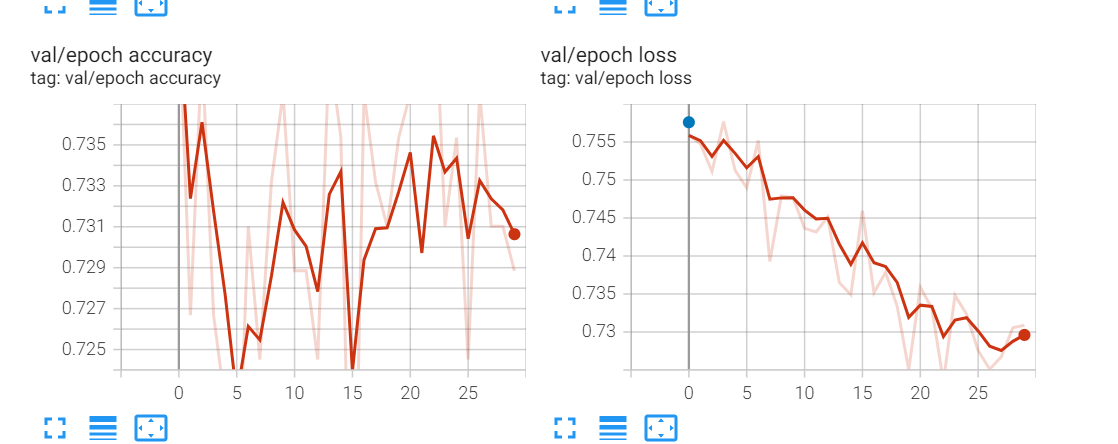

## Нейронка №2

Потом я попробывал EfficientNetB3 без заморозки слоёв. Она использует 12GB памяти для тринеровки, что у меня есть, но уже впритык.

Тут на графике сравнение с предидушей замароженной EfficientNetB4.
Голубая это B3, а красная -- B4.
Тут мы видем что B3 **полностью** запомнила наш небольшой трейнинг сет, на 2К картинок, и с 10ой эпохи выдаёт идеальный предсказания.
Это прям textbook определение оверфитинга.
Поэтому в нашей задачке нужны аугментации.

Но, несмотря на это, метрики на тестовых данных всеравно лучше предидущей модели.

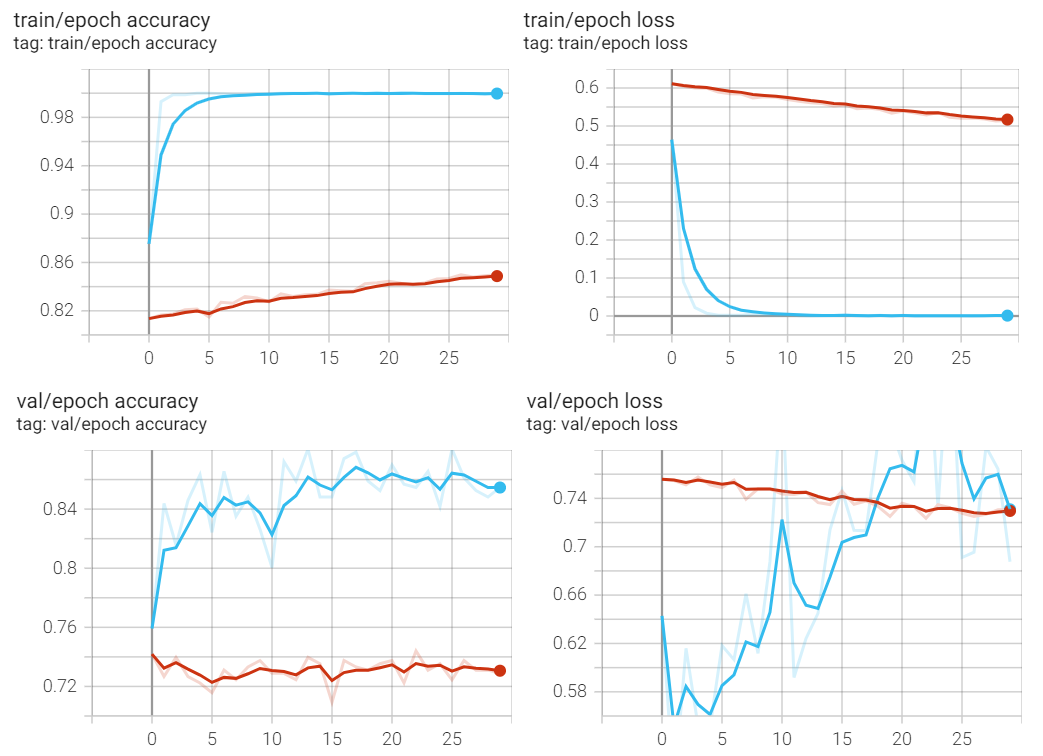

## Нейронки №3, №4 и №5

Потом я запустил полностью отморожунную B3 сеть с тремя вариантами аугментации.
Моя аугментация (красным на графике), которая рисует чёрные квадраты, работает относительно средненько: хуже чем AutoAugment (голубой) но лучше RandomHorizontalFlip (синий), если смотреть на accuracy.
Но для f1-score RandomHorizontalFlip получеатся лучше.

Самый лучший accuracy 0.8807 у AutoAugment, а самый лучший f1-score 0.864 тоже у AutoAugment.

На тренеровке AutoAugment заметно медленее достигает идельаного скора.

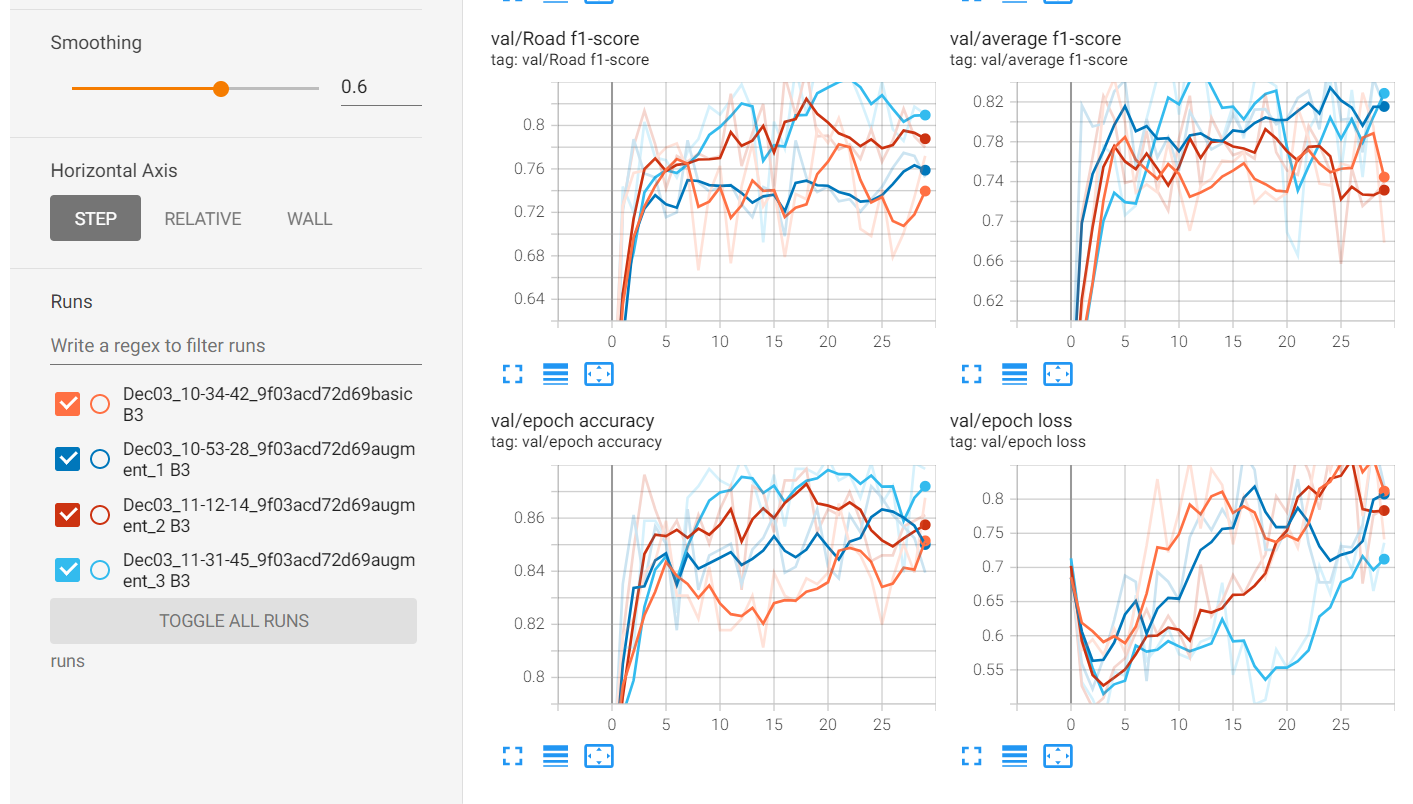



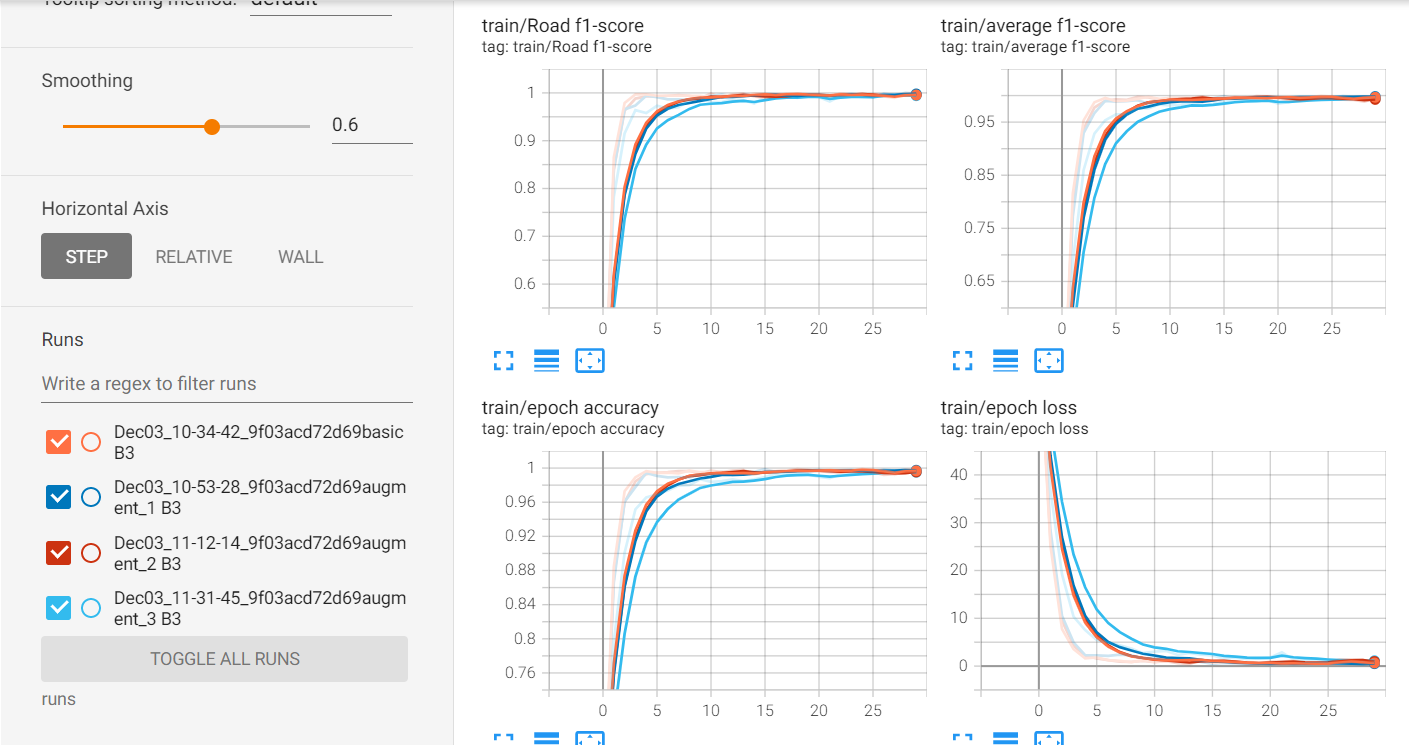

## Нейронки №6

Потом я решил скомбинировать все аугментации сразу.
Также я запустил эту тренеровку на 60 эпох, что в два раза больше всех остольных, на всякий случай.
На графике сразу понятно где она, потомучто она не толко вишнёвого цвета, но ещё и в два раза длинее.

Получился очень хороший результат accuracy 0.9002, но средний f1-score только 0.75.
Он страдает из-за класса `Bmx`, который у нас самый редкий: в тестовом датасете их всего три штуки.
Для всех остальных классов f1-score продолжает увеличиваться, особенно для `City` и `Mtb`.

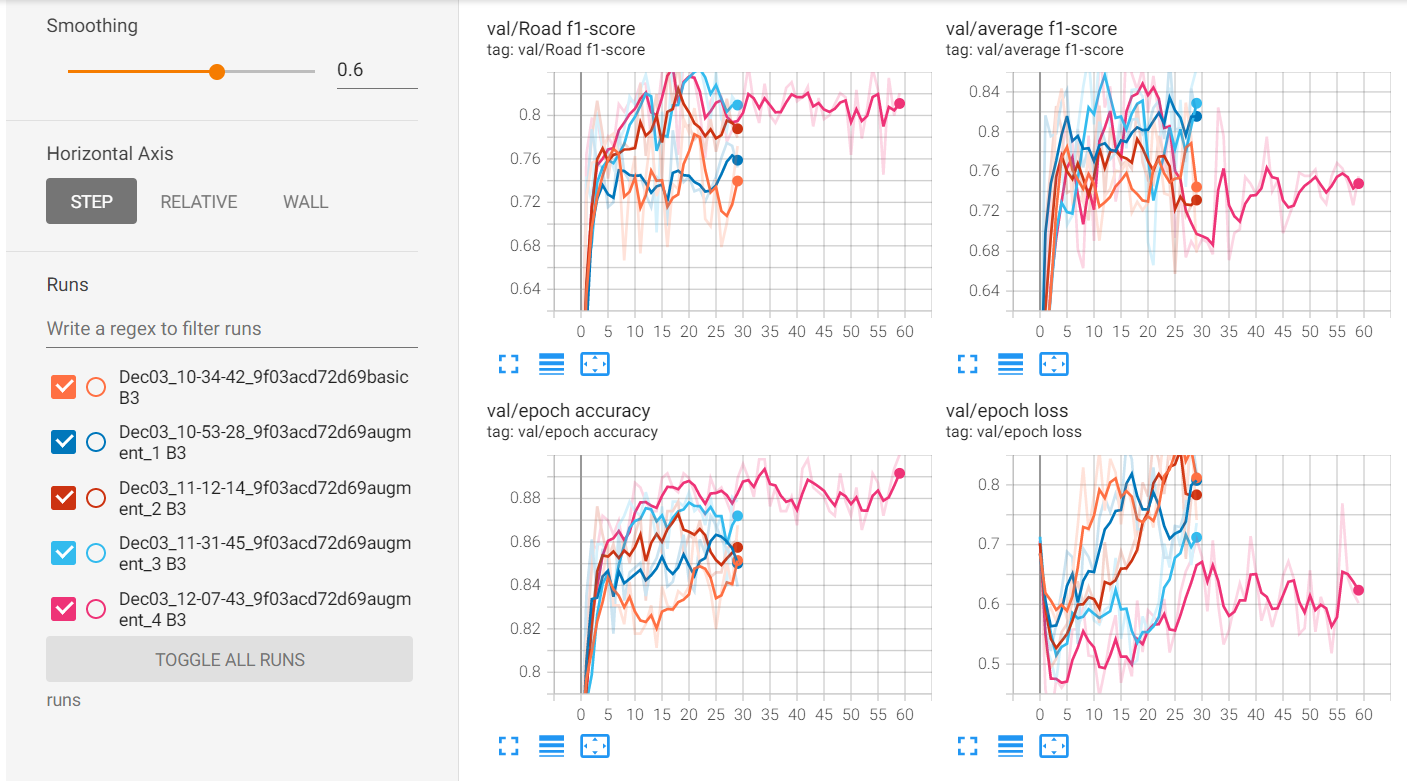

Эту модельку я сохранил на гоогл диске: https://drive.google.com/file/d/1-nMCzhJyX8pKLJPjgqxxMFmyodEEKioo

Итоги: лучший accuracy 90%, лучший f1-score 86.4%